In [11]:
from keras.models import load_model
import os
import generator as gen
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [20]:
path1 = os.path.join('object_association', 'pixel_feature_matching.hdf5')
path2 = os.path.join('object_association', 'complex_feature_matching.hdf5')

In [21]:
association_model = load_model(path2)

In [22]:
testing_gen = gen.generator(use='test', image_size = (224,224,3), batch_size=1)
counter = 0
trigger = 0.5
labels = []
predictions = []
TP = []
FN = []
FP = []
TN = []
images1 = []
images2 = []

#print('{}\t{}\t|{}\t{}\t{}\t{}'.format('lab', 'pred', 'tp', 'fn', 'fp', 'tn'))

while True:
    (image1, image2), tag = next(testing_gen)
    images1.append(image1)
    images2.append(image2)
    labels.append(tag)
    likelihood = association_model.predict([image1, image2], verbose=0)
    pred = 0
    if likelihood >= trigger:
        pred = 1
    predictions.append(pred)
    tp = 0
    fn = 0
    fp = 0
    tn = 0
    if tag:
        if pred:
            tp = 1
        else:
            fn = 1
    else:
        if pred:
            fp = 1
        else:
            tn = 1
    TP.append(tp)
    FN.append(fn)
    FP.append(fp)
    TN.append(tn)
    
    counter +=1
    if (sum(TP) >= 10) and (sum(FN) >= 10) and (sum(FP) >= 10) and (sum(TN) >= 10):
        break

    #print('{}\t{}\t|{}\t{}\t{}\t{}'.format(tag, pred, tp, fn, fp, tn))
    
    

In [23]:
TP_imgs = [(i1, i2) for (i1, i2, tp) in zip(images1, images2, TP) if tp]
FN_imgs = [(i1, i2) for (i1, i2, fn) in zip(images1, images2, FN) if fn]
FP_imgs = [(i1, i2) for (i1, i2, fp) in zip(images1, images2, FP) if fp]
TN_imgs = [(i1, i2) for (i1, i2, tn) in zip(images1, images2, TN) if tn]
print(np.shape(TP_imgs))
print(np.shape(FN_imgs))
print(np.shape(FP_imgs))
print(np.shape(TN_imgs))

(31, 2, 1, 224, 224, 3)
(10, 2, 1, 224, 224, 3)
(23, 2, 1, 224, 224, 3)
(25, 2, 1, 224, 224, 3)


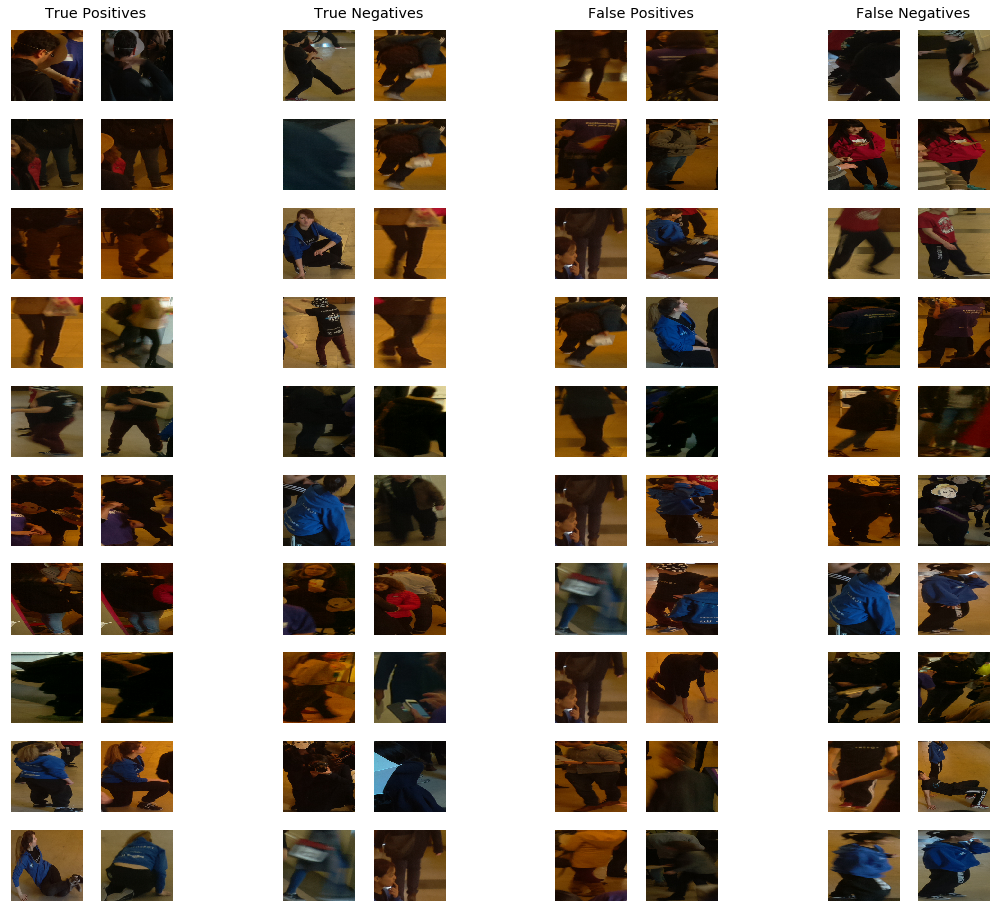

In [24]:
rows = 10
fig, axes = plt.subplots(nrows=rows, ncols=11, figsize=(14, rows*1.25))

def plot_image(img):
    img1_out = np.copy(img) * 255
    img1_out=img1_out.astype(np.uint8)
    return cv2.cvtColor(img1_out, cv2.COLOR_BGR2RGB)
    
all_match_type = ['True Positives', '', '', 'True Negatives', '', '', 'False Positives', '', '', 'False Negatives']

for row, (TP, TN, FP, FN) in enumerate(zip(TP_imgs[:rows], TN_imgs[:rows], FP_imgs[:rows], FN_imgs[:rows])):
    pairs = (TP, TN, FP, FN)
    for col1, pair in enumerate(pairs):
        for col2, img in enumerate(pair):
            img = img[0]
            col = (col1 * (len(pair) + 1)) + col2 
            axes[row,col].imshow(plot_image(img))
            
for ax in axes.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
        
pad = 5
for ax, col in zip(axes[0], all_match_type):
    ax.annotate(col, xy=(1.2, 1.1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline')
    
fig.tight_layout()
#fig.subplots_adjust(left=.01)
plt.show()

In [25]:
fig.savefig('figures/8_1_pixel.png', bbox_inches='tight')